In [15]:
from cebra import CEBRA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
df = pd.read_hdf("data/ID18150/Day2/DataFrame_Imaging_dFF_18150_day2.h5")

In [32]:
# Get a list of columns whose names are of numerical type
numerical_columns = [col for col in df.columns if type(col) == int]

#Feature matrix
X = df[numerical_columns].values

<Axes: >

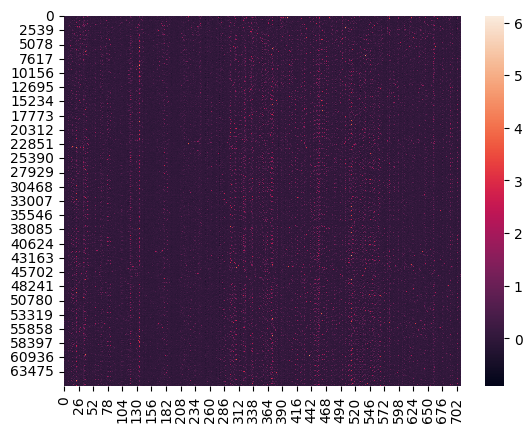

In [33]:
sns.heatmap(X)

In [34]:
single_cebra_time = CEBRA(
    batch_size=512,
    output_dimension=3,
    device="cuda_if_available",
    distance="cosine",
    learning_rate=3e-4,
    time_offsets=10
)
U = single_cebra_time.fit_transform(X)

In [42]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot components in U
for i in range(U.shape[1]):
    ax1.plot(df.Time, U[:, i], label=f'Component {i+1}')
ax1.set_ylabel('Component Value')
ax1.set_title('Line Plot of Components in U')
ax1.legend()

# Plot Pump data
sns.barplot(data=df, x='Time', y='Pump', ax=ax2)
ax2.set_xlabel('Time')
ax2.set_ylabel('Pump')
ax2.set_title('Pump Plot')

plt.tight_layout()
plt.show()